## Library

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

## Hyperparameters

In [20]:
epoch = 10
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Load

In [27]:
# Fashion MNIST
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

## AutoEncoder

In [28]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    # Encoder는 간단한 신경망으로 분류모델처럼 생김
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128), # fashion mnist가 28 * 28인걸 128로 줄임
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3), # 입력의 특징을 3차원으로 압축 (출력값이 바로 잠재 변수)
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # 28 * 28로 복원
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28 * 28),
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x) # 잠재 변수 만들기
    decoded = self.decoder(encoded) # decoder를 통해 복원
    return encoded, decoded

In [29]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 5e-3)
criterion = nn.MSELoss()

In [30]:
view_data = trainset.data[:5].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor) / 255. # 픽셀의 색상값이 0 ~ 255이므로 255로 나눔

## 학습

In [8]:
def train(autoencoder, traian_loader):
  autoencoder.train()
  for step, (x, label) in enumerate(train_loader):
    x = x.view(-1, 28 * 28).to(device)
    y = x.view(-1, 28 * 28).to(device) # x와 y 모두 원본이미지인 것을 주의
    label = label.to(device)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구함
    optimizer.zero_grad() # 기울기 초기화
    loss.backward() # 기울기 구함
    optimizer.step() # 최적화 진행

Epoch : 1


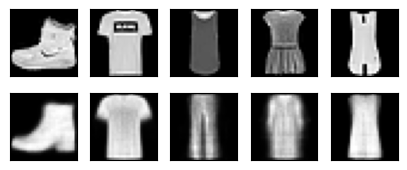

Epoch : 2


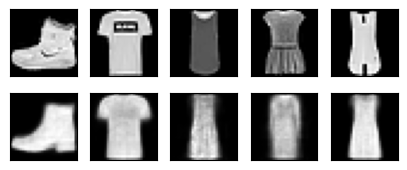

Epoch : 3


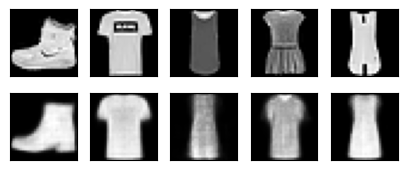

Epoch : 4


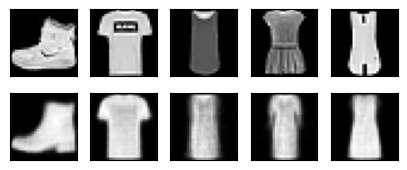

Epoch : 5


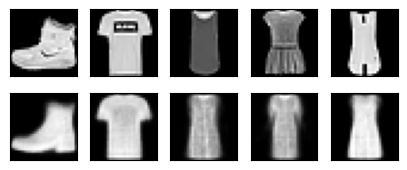

Epoch : 6


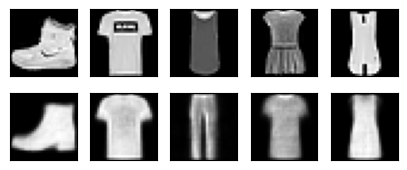

Epoch : 7


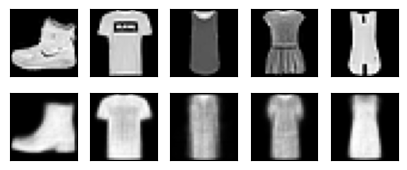

Epoch : 8


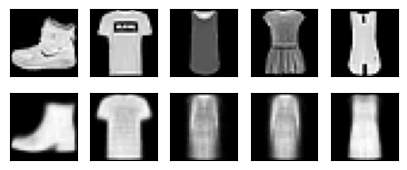

Epoch : 9


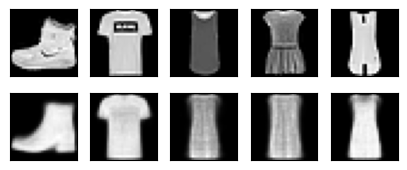

Epoch : 10


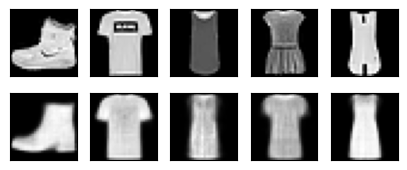

In [12]:
for epoch in range(1, epoch + 1):
  train(autoencoder, train_loader)

  test_x = view_data.to(device)
  _, decoded_data = autoencoder(test_x)

  f, a = plt.subplots(2, 5, figsize = (5, 2))
  print('Epoch : {}'.format(epoch))
  for i in range(5):
    img = np.reshape(view_data.data.numpy()[i], (28, 28)) # 텐서를 넘파이로 변환
    a[0][i].imshow(img, cmap = 'gray')
    a[0][i].set_xticks(()); a[0][i].set_yticks(())

  for i in range(5):
    img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap = 'gray')
    a[1][i].set_xticks(()); a[1][i].set_yticks(())
  plt.show()

In [13]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28 * 28) # 원본 이미지 200개 준비
view_data = view_data.type(torch.FloatTensor) / 255.
test_x = view_data.to(device)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to('cpu')

In [16]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize = (10, 8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()
# 잠재변수의 각 차원을 numpy행렬로 변환
# label도 numpy행렬로 변환
labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels): # zip()은 같은 길이의 행렬들을 모아 순서대로 묶어줌
  name = CLASSES[s]
  color = cm.rainbow(int(255 * s / 9))
  ax.text(x, y, z, name, backgroundcolor = color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

<Figure size 1000x800 with 0 Axes>

In [31]:
# 잡음 더하기
def add_noise(img):
  noise = torch.randn(img.size()) * 0.2
  noisy_img = img + noise

  return noisy_img

In [34]:
# 학습코드에 노이즈 더하기 추가
def train(autoencoder, train_loader):
  autoencoder.train()
  avg_loss = 0
  for step, (x, label) in enumerate(train_loader):
    noisy_x = add_noise(x) # 입력에 노이즈 더하기
    noisy_y = noisy_x.view(-1, 28 * 28).to(device)
    y = x.view(-1, 28 * 28).to(device)

    label = label.to(device)
    encoded, decoded = autoencoder(noisy_x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item() # 평균 오차값 관찰

  return avg_loss / len(train_loader)

In [33]:
for epoch in range(1, epoch + 1):
  loss = train(autoencoder, train_loader)
  print('Epoch : {}, Loss : {}'.format(epoch, loss))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x128)